In [ ]:

%load_ext autoreload
%autoreload 2
from pandas import DataFrame
%matplotlib inline
import vectorbtpro as vbt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from configs.config import Config
from vectorbtpro.data.custom import LocalDataT
from configs.comparisonConfig import ComparisonConfig
from configs.testDataConfig import TestDataConfig
import tensorflow as tf
from services.createPortfolioWrap import createPortfolioWrap, fetchComparison
from services.createHistogramAndComparison import createHistogram
from services.createHistogramAndComparison import createComparison

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

'''
    This notebook creates and tests simple models and combines them with the machine learning models.
'''


In [6]:
from pandas import Series

def makePort(close: Series, longEntries: Series, longExits: Series, shortEntries, shortExits: Series):
    pf: Portfolio = vbt.Portfolio.from_signals(
        close=close,
        short_entries=shortEntries,
        short_exits=shortExits,
        long_entries=longEntries,
        long_exits=longExits,
        size=10000,
        size_type='value',
        init_cash='auto',
        tp_stop=0.3,
        sl_stop=0.03,
        # https://vectorbt.pro/pvt_d904e513/documentation/portfolio/from-signals/#stop-orders
    )
    return pf



In [ ]:
comparisonEthUsd50 = createComparison(TestDataConfig.symbolConfig("X:ETHUSD"),
                                      ComparisonConfig(Config.otherDir, "50", "X:ETHUSD"),
                                      "longEntry50", "shortEntry50")

In [8]:
pf50EthWrap = createPortfolioWrap(Config.otherDir, Config.relativeSymbolDownloadDataPath('X:ETHUSD'),
                                  'X:ETHUSD', 50, .75, .6)
pf50eth = pf50EthWrap.portfolio
pf50eth.stats()

Start                         2017-01-06 02:00:00+00:00
End                           2022-12-31 23:00:00+00:00
Period                                            52448
Start Value                                10381.942635
Min Value                                   9881.278539
Max Value                                  86473.097059
End Value                                  83713.770211
Total Return [%]                             706.340135
Benchmark Return [%]                       11936.858006
Total Time Exposure [%]                        65.57924
Max Gross Exposure [%]                       102.031351
Max Drawdown [%]                              14.852369
Max Drawdown Duration                            7084.0
Total Orders                                       1311
Total Fees Paid                                     0.0
Total Trades                                        937
Win Rate [%]                                  38.675214
Best Trade [%]                                  

In [9]:
xmrPeriod=50
pfXmrWrap = createPortfolioWrap(Config.otherDir, Config.relativeSymbolDownloadDataPath('X:XMRUSD'),
                                  'X:XMRUSD', xmrPeriod, .75, .6)
pf50xmr = pfXmrWrap.portfolio
pf50xmr.stats()

Start                         2017-01-06 22:00:00+00:00
End                           2022-12-31 23:00:00+00:00
Period                                            52156
Start Value                                10659.462025
Min Value                                   9718.838667
Max Value                                  46464.677443
End Value                                  35043.745411
Total Return [%]                             228.757167
Benchmark Return [%]                         989.595376
Total Time Exposure [%]                       54.338906
Max Gross Exposure [%]                       100.904923
Max Drawdown [%]                              29.141236
Max Drawdown Duration                           15618.0
Total Orders                                        990
Total Fees Paid                                     0.0
Total Trades                                        630
Win Rate [%]                                  30.047695
Best Trade [%]                                  

In [10]:
pfXmrWrap.longEntries

Open time
2017-01-06 22:00:00+00:00    False
2017-01-06 23:00:00+00:00    False
2017-01-07 00:00:00+00:00    False
2017-01-07 01:00:00+00:00    False
2017-01-07 02:00:00+00:00    False
                             ...  
2022-12-31 19:00:00+00:00    False
2022-12-31 20:00:00+00:00    False
2022-12-31 21:00:00+00:00    False
2022-12-31 22:00:00+00:00    False
2022-12-31 23:00:00+00:00    False
Length: 52156, dtype: bool

In [11]:
# pf50XmrWrap already contains the portfolio but I am recreating it to experiment
from vectorbtpro import Portfolio

pf= makePort(pfXmrWrap.close, pfXmrWrap.longEntries, pfXmrWrap.longExits,
         pfXmrWrap.shortEntries, pfXmrWrap.shortExits)


pf.stats()


Start                         2017-01-06 22:00:00+00:00
End                           2022-12-31 23:00:00+00:00
Period                                            52156
Start Value                                10659.462025
Min Value                                   9718.838667
Max Value                                  46464.677443
End Value                                  35043.745411
Total Return [%]                             228.757167
Benchmark Return [%]                         989.595376
Total Time Exposure [%]                       54.338906
Max Gross Exposure [%]                       100.904923
Max Drawdown [%]                              29.141236
Max Drawdown Duration                           15618.0
Total Orders                                        990
Total Fees Paid                                     0.0
Total Trades                                        630
Win Rate [%]                                  30.047695
Best Trade [%]                                  

In [12]:
comparison = fetchComparison(Config.otherDir, xmrPeriod, 'X:XMRUSD')

pf= makePort(pfXmrWrap.close, comparison.actualLongEntry.astype('bool'), comparison.actualShortEntry.astype('bool'),
             comparison.actualShortEntry.astype('bool'), comparison.actualLongEntry.astype('bool'))

pf.stats()

Start                         2017-01-06 22:00:00+00:00
End                           2022-12-31 23:00:00+00:00
Period                                            52156
Start Value                                     10300.0
Min Value                                   9997.993723
Max Value                                 772011.355981
End Value                                 771946.027966
Total Return [%]                            7394.621631
Benchmark Return [%]                         989.595376
Total Time Exposure [%]                       95.584401
Max Gross Exposure [%]                       100.040134
Max Drawdown [%]                                8.88277
Max Drawdown Duration                             282.0
Total Orders                                        754
Total Fees Paid                                     0.0
Total Trades                                        620
Win Rate [%]                                   90.95315
Best Trade [%]                                  

In [13]:
from configs.featuresShiftedConfig import FeaturesShiftedConfig
conf = FeaturesShiftedConfig(Config.otherDir, "X:XMRUSD")
hdf: LocalDataT = vbt.HDFData.fetch(conf.relativeFeaturesShiftedPath)
features = hdf.data[conf.featuresShiftedKey]
#https://github.com/mellertson/talib-macd-example/blob/master/talib-macd-matplotlib-example.py
features.macd_signal

Open time
2017-01-01 03:00:00+00:00    0.017629
2017-01-01 07:00:00+00:00    0.017629
2017-01-01 10:00:00+00:00    0.017629
2017-01-01 11:00:00+00:00    0.017629
2017-01-01 16:00:00+00:00    0.017629
                               ...   
2022-12-31 19:00:00+00:00    0.280314
2022-12-31 20:00:00+00:00    0.324319
2022-12-31 21:00:00+00:00    0.363646
2022-12-31 22:00:00+00:00    0.401938
2022-12-31 23:00:00+00:00    0.422778
Name: macd_signal, Length: 52277, dtype: float64

In [14]:
features

,CurrentOpen,Open,High,Low,Close,Volume,Trade count,VWAP,ad_real,add_real,...,wma_real,outWQA1,longEntry10,shortEntry10,longEntry20,shortEntry20,longEntry50,shortEntry50,longEntry100,shortEntry100
Open time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 03:00:00+00:00,13.486,13.648,13.648,13.640,13.64,13.420157,2.0,13.6404,-13.420157,27.288,...,134.678260,0.5,0,0,0,0,0,0,0,0
2017-01-01 07:00:00+00:00,13.700,13.486,13.640,13.486,13.64,13.879843,3.0,13.4981,0.459686,27.126,...,134.678260,0.5,0,0,0,0,0,0,0,0
2017-01-01 10:00:00+00:00,13.500,13.700,13.700,13.700,13.70,9.124068,1.0,13.7000,0.459686,27.400,...,134.678260,0.5,1,0,1,0,1,0,1,0
2017-01-01 11:00:00+00:00,13.750,13.500,13.500,13.500,13.50,14.798901,3.0,13.5000,0.459686,27.000,...,134.678260,0.5,0,0,0,0,0,0,0,0
2017-01-01 16:00:00+00:00,13.800,13.750,13.750,13.750,13.75,10.000000,2.0,13.7500,0.459686,27.500,...,134.678260,0.5,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,147.180,147.810,148.020,147.140,147.59,74.698918,66.0,147.5846,-788116.651168,295.160,...,146.379290,0.5,0,0,0,0,0,0,0,0
2022-12-31 20:00:00+00:00,147.690,147.180,148.610,147.140,147.75,808.734991,115.0,147.7793,-788254.191132,295.750,...,146.484129,0.5,0,0,0,0,0,0,0,0
2022-12-31 21:00:00+00:00,148.090,147.690,148.170,147.470,147.68,94.169371,73.0,147.6603,-788291.858881,295.640,...,146.578000,0.5,0,1,1,0,1,0,1,0


In [15]:

#https://github.com/mellertson/talib-macd-example/blob/master/talib-macd-matplotlib-example.py
resultLongEntries = (features.macd_macd > features.macd_signal) & (features.rsi_rsi<50) #& pfXmrWrap.longEntries
resultShortEntries = (features.macd_macd < features.macd_signal) & (features.rsi_rsi>50) #& pfXmrWrap.shortEntries


In [16]:
a = DataFrame(index= pfXmrWrap.close.index)
a['resultLongEntries'] = resultLongEntries
a['resultShortEntries'] = resultShortEntries
a['longEntries'] = pfXmrWrap.longEntries
a['macd_macd'] = features.macd_macd
a['macd_signal'] = features.macd_signal
a['rsi_rsi'] = features.rsi_rsi

#pf50XmrWrap.longEntries
a.loc[a['resultLongEntries'] == True]


,resultLongEntries,resultShortEntries,longEntries,macd_macd,macd_signal,rsi_rsi
Open time,,,,,,
2017-01-07 00:00:00+00:00,True,False,False,-0.636514,-0.642999,43.722888
2017-01-07 02:00:00+00:00,True,False,False,-0.520503,-0.601197,42.416760
2017-01-07 10:00:00+00:00,True,False,False,-0.586706,-0.652092,47.434555
2017-01-07 11:00:00+00:00,True,False,False,-0.493406,-0.620355,49.972876
2017-01-07 12:00:00+00:00,True,False,False,-0.449194,-0.586123,45.987641
...,...,...,...,...,...,...
2022-12-24 18:00:00+00:00,True,False,False,-0.123687,-0.252634,49.935382
2022-12-28 04:00:00+00:00,True,False,False,-0.112406,-0.123488,46.911089
2022-12-31 01:00:00+00:00,True,False,False,0.138382,0.074444,47.852079


In [17]:
from vectorbtpro import Portfolio, Ranges
from vectorbtpro._typing import SeriesFrame, MaybeTuple

longs: MaybeTuple[SeriesFrame] = resultLongEntries.vbt.signals.clean(resultShortEntries)
shorts: MaybeTuple[SeriesFrame] = resultShortEntries.vbt.signals.clean(resultLongEntries)
cleanLongEntries: SeriesFrame = longs[0]
cleanLongExits: SeriesFrame = longs[1]
cleanShortEntries: SeriesFrame = shorts[0]
cleanShortExits: SeriesFrame = shorts[1]

In [18]:
pf= makePort(pfXmrWrap.close, cleanLongEntries, cleanLongExits,
             cleanShortEntries, cleanShortExits)

pf.stats()

Start                         2017-01-01 03:00:00+00:00
End                           2022-12-31 23:00:00+00:00
Period                                            52277
Start Value                                     10000.0
Min Value                                   9770.198666
Max Value                                  45494.796101
End Value                                  43562.794401
Total Return [%]                             335.627944
Benchmark Return [%]                         989.595376
Total Time Exposure [%]                       45.318209
Max Gross Exposure [%]                       104.704128
Max Drawdown [%]                              29.490004
Max Drawdown Duration                           11330.0
Total Orders                                       1720
Total Fees Paid                                     0.0
Total Trades                                       1212
Win Rate [%]                                  46.738233
Best Trade [%]                                  

In [ ]:
comparisonEthUsd50 = createComparison(TestDataConfig.symbolConfig("X:ETHUSD"),
                                      ComparisonConfig(Config.otherDir, "50", "X:ETHUSD"),
                                      "longEntry50", "shortEntry50")

In [20]:
pf50EthWrap = createPortfolioWrap(Config.otherDir, Config.relativeSymbolDownloadDataPath('X:ETHUSD'),
                                  'X:ETHUSD', 50, .75, .6)
pf50eth = pf50EthWrap.portfolio
pf50eth.stats()

Start                         2017-01-06 02:00:00+00:00
End                           2022-12-31 23:00:00+00:00
Period                                            52448
Start Value                                10381.942635
Min Value                                   9881.278539
Max Value                                  86473.097059
End Value                                  83713.770211
Total Return [%]                             706.340135
Benchmark Return [%]                       11936.858006
Total Time Exposure [%]                        65.57924
Max Gross Exposure [%]                       102.031351
Max Drawdown [%]                              14.852369
Max Drawdown Duration                            7084.0
Total Orders                                       1311
Total Fees Paid                                     0.0
Total Trades                                        937
Win Rate [%]                                  38.675214
Best Trade [%]                                  

In [21]:
xmrPeriod=10
pfXmrWrap = createPortfolioWrap(Config.otherDir, Config.relativeSymbolDownloadDataPath('X:XMRUSD'),
                                'X:XMRUSD', xmrPeriod, .5, .5)
                                  #'X:XMRUSD', xmrPeriod, .75, .6) # for 50
pfXmr = pfXmrWrap.portfolio
pfXmr.stats()

Start                         2017-01-06 22:00:00+00:00
End                           2022-12-31 23:00:00+00:00
Period                                            52156
Start Value                                13256.444767
Min Value                                       10000.0
Max Value                                  110558.68045
End Value                                 109744.690919
Total Return [%]                              727.85915
Benchmark Return [%]                         989.595376
Total Time Exposure [%]                       81.139274
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              29.469382
Max Drawdown Duration                            5997.0
Total Orders                                       3482
Total Fees Paid                                     0.0
Total Trades                                       2889
Win Rate [%]                                  41.066482
Best Trade [%]                                  

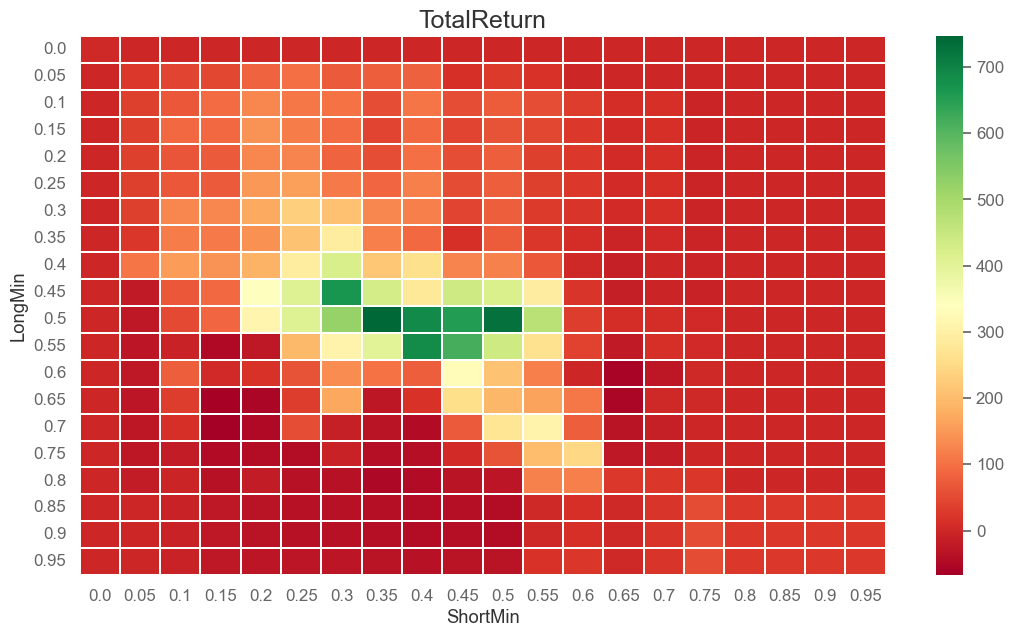

In [22]:
comparison = fetchComparison(Config.otherDir, 10, 'X:XMRUSD')
comparison
createHistogram(comparison, Config.relativeSymbolDownloadDataPath("X:XMRUSD"),
                "X:XMRUSD", None)

In [23]:
from configs.featuresShiftedConfig import FeaturesShiftedConfig
conf = FeaturesShiftedConfig(Config.otherDir, "X:XMRUSD")
hdf: LocalDataT = vbt.HDFData.fetch(conf.relativeFeaturesShiftedPath)
features = hdf.data[conf.featuresShiftedKey]
#https://github.com/mellertson/talib-macd-example/blob/master/talib-macd-matplotlib-example.py
features.macd_signal

Open time
2017-01-01 03:00:00+00:00    0.017629
2017-01-01 07:00:00+00:00    0.017629
2017-01-01 10:00:00+00:00    0.017629
2017-01-01 11:00:00+00:00    0.017629
2017-01-01 16:00:00+00:00    0.017629
                               ...   
2022-12-31 19:00:00+00:00    0.280314
2022-12-31 20:00:00+00:00    0.324319
2022-12-31 21:00:00+00:00    0.363646
2022-12-31 22:00:00+00:00    0.401938
2022-12-31 23:00:00+00:00    0.422778
Name: macd_signal, Length: 52277, dtype: float64

In [24]:
features

,CurrentOpen,Open,High,Low,Close,Volume,Trade count,VWAP,ad_real,add_real,...,wma_real,outWQA1,longEntry10,shortEntry10,longEntry20,shortEntry20,longEntry50,shortEntry50,longEntry100,shortEntry100
Open time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 03:00:00+00:00,13.486,13.648,13.648,13.640,13.64,13.420157,2.0,13.6404,-13.420157,27.288,...,134.678260,0.5,0,0,0,0,0,0,0,0
2017-01-01 07:00:00+00:00,13.700,13.486,13.640,13.486,13.64,13.879843,3.0,13.4981,0.459686,27.126,...,134.678260,0.5,0,0,0,0,0,0,0,0
2017-01-01 10:00:00+00:00,13.500,13.700,13.700,13.700,13.70,9.124068,1.0,13.7000,0.459686,27.400,...,134.678260,0.5,1,0,1,0,1,0,1,0
2017-01-01 11:00:00+00:00,13.750,13.500,13.500,13.500,13.50,14.798901,3.0,13.5000,0.459686,27.000,...,134.678260,0.5,0,0,0,0,0,0,0,0
2017-01-01 16:00:00+00:00,13.800,13.750,13.750,13.750,13.75,10.000000,2.0,13.7500,0.459686,27.500,...,134.678260,0.5,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,147.180,147.810,148.020,147.140,147.59,74.698918,66.0,147.5846,-788116.651168,295.160,...,146.379290,0.5,0,0,0,0,0,0,0,0
2022-12-31 20:00:00+00:00,147.690,147.180,148.610,147.140,147.75,808.734991,115.0,147.7793,-788254.191132,295.750,...,146.484129,0.5,0,0,0,0,0,0,0,0
2022-12-31 21:00:00+00:00,148.090,147.690,148.170,147.470,147.68,94.169371,73.0,147.6603,-788291.858881,295.640,...,146.578000,0.5,0,1,1,0,1,0,1,0


In [25]:
#https://github.com/mellertson/talib-macd-example/blob/master/talib-macd-matplotlib-example.py
#resultLongEntries = (features.macd_macd > features.macd_signal) & (features.rsi_rsi<50) & pfXmrWrap.longEntries
#resultShortEntries = (features.macd_macd < features.macd_signal) & (features.rsi_rsi>50) & pfXmrWrap.shortEntries
#resultLongEntries = (features.macd_macd > features.macd_signal) &  pfXmrWrap.longEntries
#resultShortEntries = (features.macd_macd < features.macd_signal) & pfXmrWrap.shortEntries
resultLongEntries = (features.rsi_rsi<40) & pfXmrWrap.longEntries
resultShortEntries =  (features.rsi_rsi>40) & pfXmrWrap.shortEntries
resultLongEntries.value_counts()
#pfXmrWrap.longEntries.value_counts()
resultShortEntries.value_counts()

False    51696
True       581
dtype: int64

In [26]:
a = DataFrame(index= pfXmrWrap.close.index)
a['resultLongEntries'] = resultLongEntries
a['resultShortEntries'] = resultShortEntries
a['longEntries'] = pfXmrWrap.longEntries
a['macd_macd'] = features.macd_macd
a['macd_signal'] = features.macd_signal
a['rsi_rsi'] = features.rsi_rsi

#pf50XmrWrap.longEntries
a.loc[a['resultLongEntries'] == True]


,resultLongEntries,resultShortEntries,longEntries,macd_macd,macd_signal,rsi_rsi
Open time,,,,,,
2017-01-06 22:00:00+00:00,True,False,True,-0.695733,-0.631860,36.106502
2017-02-20 10:00:00+00:00,True,False,True,-0.264489,-0.161833,29.217862
2017-02-24 07:00:00+00:00,True,False,True,-0.104974,0.001686,33.294638
2017-03-07 08:00:00+00:00,True,False,True,-0.029465,0.073611,36.924227
2017-03-07 13:00:00+00:00,True,False,True,-0.226738,-0.083064,29.356953
...,...,...,...,...,...,...
2022-11-28 04:00:00+00:00,True,False,True,-0.875898,-0.375412,35.293670
2022-12-16 13:00:00+00:00,True,False,True,-0.538794,-0.191616,33.995701
2022-12-17 03:00:00+00:00,True,False,True,-1.902292,-1.313362,20.277108


In [27]:
from vectorbtpro import Portfolio, Ranges
from vectorbtpro._typing import SeriesFrame, MaybeTuple

longs: MaybeTuple[SeriesFrame] = resultLongEntries.vbt.signals.clean(resultShortEntries)
shorts: MaybeTuple[SeriesFrame] = resultShortEntries.vbt.signals.clean(resultLongEntries)
cleanLongEntries: SeriesFrame = longs[0]
cleanLongExits: SeriesFrame = longs[1]
cleanShortEntries: SeriesFrame = shorts[0]
cleanShortExits: SeriesFrame = shorts[1]

In [28]:
pf= makePort(pfXmrWrap.close, cleanLongEntries, cleanLongExits,
             cleanShortEntries, cleanShortExits)

pf.stats()

Start                         2017-01-01 03:00:00+00:00
End                           2022-12-31 23:00:00+00:00
Period                                            52277
Start Value                                17858.811576
Min Value                                       10000.0
Max Value                                  58498.116704
End Value                                  56019.497032
Total Return [%]                             213.679871
Benchmark Return [%]                         989.595376
Total Time Exposure [%]                       30.401515
Max Gross Exposure [%]                        101.11932
Max Drawdown [%]                              46.753583
Max Drawdown Duration                           14262.0
Total Orders                                        700
Total Fees Paid                                     0.0
Total Trades                                        446
Win Rate [%]                                       40.0
Best Trade [%]                                  